# Escuela de ML y DL Módulo 2
# Tarea 5. Traductor utilizando un transformer.
# Arnoldo Fernando Chue Sánchez
# arnoldwork20@gmail.com
# Agosto de 2024

## Contenido
1. Planteamiento del problema
2. Planteamiento de la solución
3. Ejemplo de ejecución
4. Conclusiones
5. Referencias

## 1. Planteamiento del problema

Importar un diccionario.pkl para construir un keras-transformer como traductor, de un idioma fuente (francés, alemán, italiano, etc.) al lenguaje español, deberá hacer lo siguiente:
- Buscar el diccionario para el idioma fuente a español
- Cargarlo en la libreta TransformerTraductor.ipynb
- Entrenar el modelo transformer
- Buscar el menor error (épocas, dropout, tamaño de batch, otros parámetros)
- Concluir con ejemplos de traducción del diccionario entrenado al español.

## 2. Planteamiento de la solución

Para esta práctica voy a proponer la traducción del hebreo al español. Esto porque al ser un idioma de caracteres diferentes al español y no venir de la misma familia linguística, constituye un gran reto (lo único que se conserva en digital son los números arábigos: 0,1,2,3,4,5,6,7,8,9). Además puede resultar útil para los sacerdotes y teólogos, ya que son las personas que sí llegan a estudiar documentos en este idioma (además de quien quiera hacer turismo en Tierra Santa o para estudiosos del judaísmo).

Para esto se consiguieron datasets de Kaggle para formar el diccionario: https://www.kaggle.com/datasets/miguelcorraljr/ted-ultimate-dataset. Sólo que al ser por separado sobre Ted Talks, hay que manipularlos un poco para formar un sólo dataset-diccionario.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from pickle import load
from keras_transformer import get_model, decode
import tensorflow as tf

Ahora vamos a manipular los datasets

In [3]:
df_esp = pd.read_csv("ted_talks_es.csv", encoding="utf-8")
df_heb = pd.read_csv("ted_talks_he.csv", encoding="utf-8")

In [5]:
df_esp.head()

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Al Gore sobre cómo evitar la crisis climática,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523396,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,Con el mismo humor y humanidad que irradió en ...,Muchas gracias Chris. Y es en verdad un gran h...
1,7,"David Pogue dice ""La Simplicidad Vende""",David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920803,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,"El columnista del New York Times, David Pogue,...","Hola contestadora automática, mi vieja amiga. ..."
2,53,Un recorrido por la renovación urbana de la ma...,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664029,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"En una charla altamente emotiva, la activista ...","Si están presentes aquí hoy, y estoy muy conte..."
3,66,Ken Robinson dice que las escuelas matan la cr...,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65052534,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson plantea de manera entretenida...,"Buenos días. ¿Cómo están? Ha sido increíble, ¿..."
4,92,Hans Rosling nos muestra las mejores estadísti...,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501766,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,Una manera única de presentar datos. Con la en...,"Hace unos 10 años, emprendí la tarea de enseña..."


In [6]:
df_heb.head()

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,אל גור מדבר על פתרונות ביתים למשבר האקלימי,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523396,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,"סגן נשיא ארה""ב לשעבר אל גור מונה חמישה עשר דרכ...",תודה רבה כריס. זה אכן כבוד גדול לעלות על הבמה ...
1,7,"דיוויד פוג אומר ש-""פשטות מוכרת""",David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920845,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,"כתב ה""ניו יורק טיימס"" דיוויד פוג לוקח מטרה אל ...","משיבון, חבריי היקר. (צחוק) התקשרתי לתמיכה טכני..."
2,53,סיפורה של מג'ורה קרטר על התחדשות עירונית,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664034,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"בשיחה טעונה רגשית, הפעילה זוכת פרס מקרתור מג'ו...","אם אתם כאן היום, ואני שמחה שאתם כאן' כבר שמעתם..."
3,66,איך בתי הספר הורגים את היצירתיות,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65052109,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,סר קן רובינסון מציג טיעון משעשע ומרגש ביותר בז...,"בוקר טוב. מה שלומכם? היה נהדר, נכון? היה כיף א..."
4,92,הנס רוסלינג מציג את הנתונים הכי טובים שיצא לכם...,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501647,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,עוד לא ראיתם נתונים מוצגים בדרך זו. באמצעות הד...,לפני כעשר שנים לקחתי לעצמי את המשימה ללמד סטוד...


Vamos a usar la columna de title. Es cierto que podríamos usar también las columnas de description y de transcript. Sin embargo, el dataset se haría demasiado grande como para entrenar (se intentó hacer con el dataset completo y no se pudo entrenar la red ni en el servidor, ni en mi computadora personal). Esto porque las palabras del transcript son demasiadas y las de la description incluyen links y otros caracteres que le generan ruido al modelo

In [5]:
df_title = pd.concat([df_heb["title"], df_esp["title"]], axis=1)

In [6]:
df_title.columns = ["Hebreo", "Español"]

In [7]:
df_title.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3921 entries, 0 to 3920
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Hebreo   3298 non-null   object
 1   Español  3921 non-null   object
dtypes: object(2)
memory usage: 61.4+ KB


In [8]:
df_title.dropna(inplace=True)

In [9]:
df_title.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3298 entries, 0 to 3297
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Hebreo   3298 non-null   object
 1   Español  3298 non-null   object
dtypes: object(2)
memory usage: 77.3+ KB


Aunque sean pocos datos podemos realizar el ejercicio con este dataset, veamos hasta qué punto podemos optimizar la red.

In [10]:
df_title.to_csv("Hebreo_Español.csv", index=False, encoding="utf-8")

Ahora sí podemos pasar a la arquitectura del transformer

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
df = pd.read_csv("Hebreo_Español.csv", encoding="utf-8")

Primero creamos los tokens

In [13]:
source_tokens = [sentence.split(" ") for sentence in df.iloc[:,0]]
target_tokens = [sentence.split(" ") for sentence in df.iloc[:,1]]

In [14]:
print(source_tokens[-1])
print(target_tokens[-1])

['בימים', 'של', 'חוסר', 'וודאות,', 'חישבו', 'כמו', 'אמא']
['¿Puedes', 'resolver', 'el', 'enigma', 'de', 'la', 'sala', 'de', 'control?', '-', 'Dennis', 'Shasha']


In [15]:
def build_token_dict(token_list):
  token_dict = {
      '<PAD>': 0,
      '<START>': 1,
      '<END>': 2
  }
  for tokens in token_list:
    for token in tokens:
      if token not in token_dict:
        token_dict[token] = len(token_dict)
  return token_dict

In [16]:
source_token_dict = build_token_dict(source_tokens)
target_token_dict = build_token_dict(target_tokens)
target_token_dict_inv = {v:k for k,v in target_token_dict.items()}

Preparamos las frases del entrenamiento

In [17]:
encoder_tokens = [['<START>'] + tokens + ['<END>'] for tokens in source_tokens]
decoder_tokens = [['<START>'] + tokens + ['<END>'] for tokens in target_tokens]
output_tokens = [tokens + ['<END>'] for tokens in target_tokens]

source_max_len = max(map(len, encoder_tokens))
target_max_len = max(map(len, decoder_tokens))

encoder_tokens = [tokens + ['<PAD>']*(source_max_len-len(tokens)) for tokens in encoder_tokens]
decoder_tokens = [tokens + ['<PAD>']*(target_max_len-len(tokens)) for tokens in decoder_tokens]
output_tokens = [tokens + ['<PAD>']*(target_max_len-len(tokens)) for tokens in output_tokens ]

In [18]:
encoder_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in encoder_tokens]
decoder_input = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in decoder_tokens]
output_decoded = [list(map(lambda x: [target_token_dict[x]], tokens)) for tokens in output_tokens]

Ahora finalmente podemos pasar a la creación del transformer.

En primera instancia vamos a retomar la arquitectura que usamos en la sesión del traductor inglés-español

In [19]:
model1 = get_model(
    token_num=max(len(source_token_dict), len(target_token_dict)),
    embed_dim=32,
    encoder_num=2,
    decoder_num=2,
    head_num=4,
    hidden_dim=128,
    dropout_rate=0.05,
    use_same_embed=False,
)

model1.compile("adam", "sparse_categorical_crossentropy")
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder-Input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 Encoder-Token-Embedding (Embed  [(None, None, 32),  341504      ['Encoder-Input[0][0]']          
 dingRet)                        (10672, 32)]                                                     
                                                                                                  
 Encoder-Embedding (TrigPosEmbe  (None, None, 32)    0           ['Encoder-Token-Embedding[0][0]']
 dding)                                                                                           
                                                                                              

Nótese que usando los títulos no llegamos ni al millón de parámetros. En cambio si usábamos el dataset completo eran más de 24 millones, usando las trasncripciones eran más de 8 millones. Por lo tanto, con este dataset aunque sea pequeño, nos permite experimentar con los parámetros de la arquitectura transformer, que es el objetivo de este trabajo.

Nos preparamos para el entrenamiento

In [20]:
x = [np.array(encoder_input), np.array(decoder_input)]
y = np.array(output_decoded)

In [21]:
history1 = model1.fit(x, y, epochs=15, batch_size=32)

Epoch 1/15
104/104 [==============================] - 33s 89ms/step - loss: 4.0127
Epoch 2/15
104/104 [==============================] - 9s 85ms/step - loss: 3.2482
Epoch 3/15
104/104 [==============================] - 9s 85ms/step - loss: 3.0201
Epoch 4/15
104/104 [==============================] - 9s 83ms/step - loss: 2.8864
Epoch 5/15
104/104 [==============================] - 9s 90ms/step - loss: 2.7887
Epoch 6/15
104/104 [==============================] - 10s 93ms/step - loss: 2.7022
Epoch 7/15
104/104 [==============================] - 10s 96ms/step - loss: 2.6086
Epoch 8/15
104/104 [==============================] - 11s 102ms/step - loss: 2.5167
Epoch 9/15
104/104 [==============================] - 10s 97ms/step - loss: 2.4331
Epoch 10/15
104/104 [==============================] - 10s 97ms/step - loss: 2.3514
Epoch 11/15
104/104 [==============================] - 10s 97ms/step - loss: 2.2691
Epoch 12/15
104/104 [==============================] - 10s 97ms/step - loss: 2.1897
Epoc

Por los valores de la función de costo le podemos dejar entrenar otras 15 épocas, ya que todavía la está disminuyendo

In [22]:
history1 = model1.fit(x, y, epochs=15, batch_size=32)

Epoch 1/15
104/104 [==============================] - 9s 86ms/step - loss: 1.8895
Epoch 2/15
104/104 [==============================] - 9s 85ms/step - loss: 1.8129
Epoch 3/15
104/104 [==============================] - 9s 84ms/step - loss: 1.7348
Epoch 4/15
104/104 [==============================] - 9s 82ms/step - loss: 1.6595
Epoch 5/15
104/104 [==============================] - 10s 92ms/step - loss: 1.5959
Epoch 6/15
104/104 [==============================] - 10s 95ms/step - loss: 1.5201
Epoch 7/15
104/104 [==============================] - 10s 96ms/step - loss: 1.4363
Epoch 8/15
104/104 [==============================] - 10s 95ms/step - loss: 1.3685
Epoch 9/15
104/104 [==============================] - 10s 95ms/step - loss: 1.2965
Epoch 10/15
104/104 [==============================] - 10s 97ms/step - loss: 1.2298
Epoch 11/15
104/104 [==============================] - 10s 96ms/step - loss: 1.1542
Epoch 12/15
104/104 [==============================] - 10s 96ms/step - loss: 1.0807
Epoch

Como la función de pérdida sigue reduciendo (no se estanca mostrando sobreajuste) podemos seguir el entrenamiento e incluso con más épocas para lograr que termine de entrenar

In [23]:
history1 = model1.fit(x, y, epochs=25, batch_size=32)

Epoch 1/25
104/104 [==============================] - 10s 96ms/step - loss: 0.8308
Epoch 2/25
104/104 [==============================] - 10s 95ms/step - loss: 0.7699
Epoch 3/25
104/104 [==============================] - 10s 97ms/step - loss: 0.7259
Epoch 4/25
104/104 [==============================] - 10s 95ms/step - loss: 0.6789
Epoch 5/25
104/104 [==============================] - 10s 96ms/step - loss: 0.6273
Epoch 6/25
104/104 [==============================] - 10s 96ms/step - loss: 0.5803
Epoch 7/25
104/104 [==============================] - 10s 93ms/step - loss: 0.5394
Epoch 8/25
104/104 [==============================] - 10s 93ms/step - loss: 0.5031
Epoch 9/25
104/104 [==============================] - 9s 91ms/step - loss: 0.4717
Epoch 10/25
104/104 [==============================] - 10s 98ms/step - loss: 0.4339
Epoch 11/25
104/104 [==============================] - 10s 93ms/step - loss: 0.4127
Epoch 12/25
104/104 [==============================] - 9s 86ms/step - loss: 0.3837
Epo

Con la función de pérdida menor a 0.20, en este caso en 0.16 nuestro modelo podemos guardarlo para ejecutar pruebas en los ejemplos de ejecución.

In [24]:
model1.save("modelo1_tarea5.hdf5")

Hagamos entonces un modelo con una arquitectura del transformer más robusta

In [26]:
model2 = get_model(
    token_num=max(len(source_token_dict), len(target_token_dict)),
    embed_dim=128, # aumentamos la dimensionalidad de los vectores de palabras
    encoder_num=8, # subimos las cantidades de encoder y decoders al momento de procesar los vectores
    decoder_num=8,
    head_num=16, # aumentamos también el número de cabezas
    hidden_dim=128, # dejamos igual las capas de la red neuronal interna
    dropout_rate=0.05,
    use_same_embed=False,
)

model2.compile("adam", "sparse_categorical_crossentropy")
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder-Input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 Encoder-Token-Embedding (Embed  [(None, None, 128),  1366016    ['Encoder-Input[0][0]']          
 dingRet)                        (10672, 128)]                                                    
                                                                                                  
 Encoder-Embedding (TrigPosEmbe  (None, None, 128)   0           ['Encoder-Token-Embedding[0][0]']
 dding)                                                                                           
                                                                                            

Veamos si puede entrenar con esos 4 millones de parámetros (le daremos muchas épocas de una vez para no tener que repetir el entrenamiento)

In [27]:
history2 = model2.fit(x, y, epochs=60, batch_size=32) # mantenemos el mismo número de instancias por lote para no subir más aun los parámetros del entrenamiento

Epoch 1/60
104/104 [==============================] - 108s 416ms/step - loss: 3.6134
Epoch 2/60
104/104 [==============================] - 43s 418ms/step - loss: 3.3421
Epoch 3/60
104/104 [==============================] - 25s 239ms/step - loss: 3.3343
Epoch 4/60
104/104 [==============================] - 19s 186ms/step - loss: 3.3279
Epoch 5/60
104/104 [==============================] - 18s 170ms/step - loss: 3.3000
Epoch 6/60
104/104 [==============================] - 19s 179ms/step - loss: 3.2250
Epoch 7/60
104/104 [==============================] - 19s 182ms/step - loss: 3.1800
Epoch 8/60
104/104 [==============================] - 18s 177ms/step - loss: 3.1454
Epoch 9/60
104/104 [==============================] - 18s 170ms/step - loss: 3.1240
Epoch 10/60
104/104 [==============================] - 20s 196ms/step - loss: 3.1047
Epoch 11/60
104/104 [==============================] - 18s 175ms/step - loss: 3.0926
Epoch 12/60
104/104 [==============================] - 18s 171ms/step - l

Como podemos ver este modelo siendo mucho más complejo, tiene un entrenamiento mucho más lento. Con 60 épocas casi no reduce la pérdida, por lo que necesitaría entrenamientos mucho más largos. Justo si lo graficamos vemos que incluso pareciera que comienza a sobreajustar, pero en realidad lo que pasa es que para ajustar cada parte de la arquitectura de la red, es necesario un entrenamiento de muchas épocas.

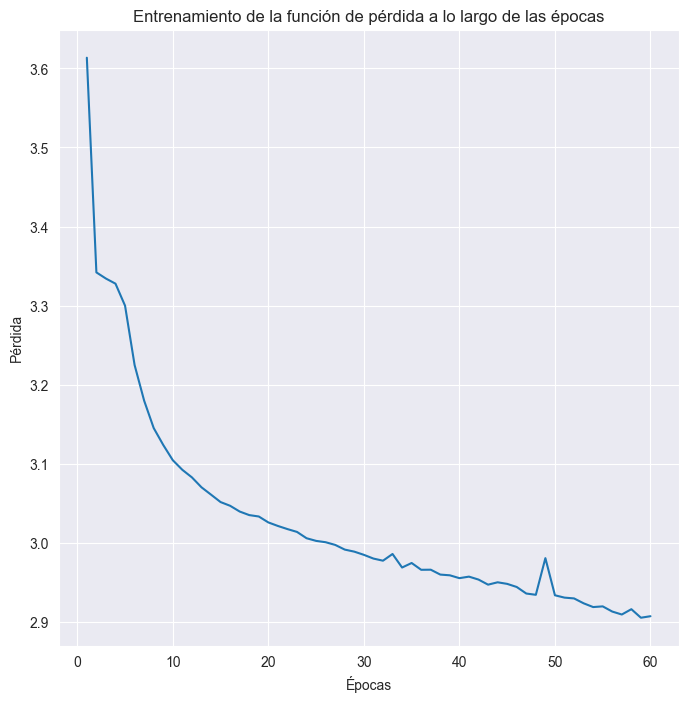

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(8,8))

loss = pd.DataFrame({'Epoch': range(1, len(history2.history['loss']) + 1), 'Loss': history2.history['loss']})
sns.lineplot(data=loss, x='Epoch', y='Loss')

plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Entrenamiento de la función de pérdida a lo largo de las épocas')
plt.show()

In [32]:
model2.save("modelo2_tarea5.hdf5")

Hagamos un modelo que sea un punto medio entre los 2 que ya tenemos: no tan pesado como este último pero tampoco tan ligero como el primero

In [33]:
model3 = get_model(
    token_num=max(len(source_token_dict), len(target_token_dict)),
    embed_dim=64, 
    encoder_num=4, 
    decoder_num=4,
    head_num=8, 
    hidden_dim=256, # esta es la única capa que aumentamos
    dropout_rate=0.05,
    use_same_embed=False,
)

model3.compile("adam", "sparse_categorical_crossentropy")
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder-Input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 Encoder-Token-Embedding (Embed  [(None, None, 64),  683008      ['Encoder-Input[0][0]']          
 dingRet)                        (10672, 64)]                                                     
                                                                                                  
 Encoder-Embedding (TrigPosEmbe  (None, None, 64)    0           ['Encoder-Token-Embedding[0][0]']
 dding)                                                                                           
                                                                                            

Aquí podemos ver que tenemos menos de 2 millones de parámetros, por lo que debería ser más ligero que el segundo, pero más complejo que el primero (ya que no llegaba al millón).

Para este último vamos a lo más robusto por ahora: 100 épocas para el entrenamiento

In [34]:
history3 = model3.fit(x, y, epochs=100, batch_size=32)

Epoch 1/100
104/104 [==============================] - 26s 84ms/step - loss: 3.7639
Epoch 2/100
104/104 [==============================] - 9s 85ms/step - loss: 3.2883
Epoch 3/100
104/104 [==============================] - 9s 88ms/step - loss: 3.1383
Epoch 4/100
104/104 [==============================] - 8s 81ms/step - loss: 3.0016
Epoch 5/100
104/104 [==============================] - 9s 89ms/step - loss: 2.9347
Epoch 6/100
104/104 [==============================] - 9s 85ms/step - loss: 2.8539
Epoch 7/100
104/104 [==============================] - 9s 91ms/step - loss: 2.7614
Epoch 8/100
104/104 [==============================] - 9s 85ms/step - loss: 2.6756
Epoch 9/100
104/104 [==============================] - 9s 84ms/step - loss: 2.5936
Epoch 10/100
104/104 [==============================] - 9s 91ms/step - loss: 2.5176
Epoch 11/100
104/104 [==============================] - 9s 89ms/step - loss: 2.4529
Epoch 12/100
104/104 [==============================] - 9s 85ms/step - loss: 2.3825


Apenas con 100 épocas logramos reducir la función de pérdida por debajo de 0.40. Por lo que podríamos darle más épocas al entrenamiento, pero para fines de nuestra práctica lo dejaremos hasta aquí

In [35]:
model3.save("modelo3_tarea5.hdf5")

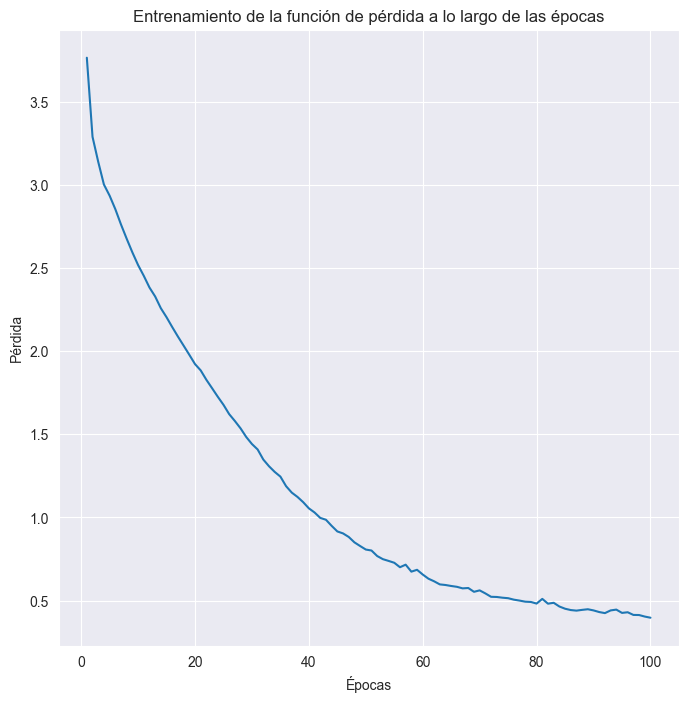

In [36]:
plt.figure(figsize=(8,8))

loss = pd.DataFrame({'Epoch': range(1, len(history3.history['loss']) + 1), 'Loss': history3.history['loss']})
sns.lineplot(data=loss, x='Epoch', y='Loss')

plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Entrenamiento de la función de pérdida a lo largo de las épocas')
plt.show()

## 3. Ejemplo de ejecución

Vamos a probar algunas frases y ver qué es lo que traduce cada modelo al español

In [38]:
def translate(sentence, model):
    sentence_tokens = [tokens + ['<END>', '<PAD>'] for tokens in [sentence.split(' ')]]
    tr_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in sentence_tokens][0]
    decoded = decode(
        model, 
        tr_input, 
        start_token = target_token_dict['<START>'],
        end_token = target_token_dict['<END>'],
        pad_token = target_token_dict['<PAD>']
    )

    print('Frase original: {}'.format(sentence))
    print('Traducción: {}'.format(' '.join(map(lambda x: target_token_dict_inv[x], decoded[1:-1]))))

In [48]:
frase1 = "שלום עולם" # se supone que ahí dice hola mundo

In [45]:
translate(frase1, model1)

1/1 [==============================] - 0s 40ms/step
Frase original: שלום עולם
Traducción: La tonalidad de ciencia orquesta del sueño TED TED


In [46]:
translate(frase1, model2)

1/1 [==============================] - 0s 82ms/step
Frase original: שלום עולם
Traducción: Cómo Cómo Cómo Cómo Cómo Cómo Cómo Cómo Cómo


In [47]:
translate(frase1, model3)

1/1 [==============================] - 0s 91ms/step
Frase original: שלום עולם
Traducción: El arte olvidado del zoótropo


Como podemos ver, las funciones de pérdida arrojan resultados completamente diferentes y algunos sin mucho sentido. Por ejemplo: el modelo 2 se nota que no logró terminar su entrenamiento y por eso regresa la misma palabra.

Probemos ahora con títulos del entrenamiento para ver qué tanto aprendió lo que se le dio

In [49]:
frase2 = "אל גור מדבר על פתרונות ביתים למשבר האקלימי" # este título dice: "Al Gore sobre cómo evitar la crisis climática"

In [50]:
translate(frase2, model1)

1/1 [==============================] - 0s 42ms/step
Frase original: אל גור מדבר על פתרונות ביתים למשבר האקלימי
Traducción: Peter Ganson hace el lenguaje de realidad sistema climática


In [51]:
translate(frase2, model2)

1/1 [==============================] - 0s 80ms/step
Frase original: אל גור מדבר על פתרונות ביתים למשבר האקלימי
Traducción: Cómo Cómo Cómo Cómo Cómo Cómo Cómo Cómo Cómo


In [52]:
translate(frase2, model3)

1/1 [==============================] - 0s 49ms/step
Frase original: אל גור מדבר על פתרונות ביתים למשבר האקלימי
Traducción: Hans Rosling: Dejen que mi conjunto de datos cambie su mentalidad.


Vemos que en este caso no se logró tampoco con títulos del entrenamiento. Lo que sí se puede ver es que el segundo modelo sí le hizo falta mucho entrenamiento, ya que no logra establecer ninguna relación entre los inputs y outputs

Probemos con lo más simple: decir "Hola"

In [53]:
frase3 = "שלום"

In [54]:
translate(frase3, model1)

1/1 [==============================] - 0s 62ms/step
Frase original: שלום
Traducción: Las fascinante humanas humanas humanas


In [55]:
translate(frase3, model3)

1/1 [==============================] - 0s 83ms/step
Frase original: שלום
Traducción: Michael Hansmeyer: La construcción de formas inimaginables


## 4. Conclusiones

En esta ocasión nuestro problema fue el bajo ajuste (bias). Los modelos que realizamos no sirvieron porque no traducen cosas con sentido. Puede que el problema desde un inicio haya sido el reto tan ambicioso de traducir entre lenguajes que no comparten el mismo alfabeto (y probablemente cambie también la forma gramatical). Por lo que aquí nos damos cuenta de lo grande que es el reto de la traducción en el procesamiento de lenguaje natural: necesitas buenas fuentes de datos y conocer el idioma para poder realizar las traducciones correctamente. Aquí lo que nos limita es el conocimiento del idioma.

Sin embargo, cabe destacar que para fines de conocer la arquitectura transformer, este trabajo fue muy útil: aprendimos cómo cambiar los parámetros, la manera en que los datos se transforman en la red y los requisitos para el entrenamiento. Por lo que a nivel de aprendizaje y los objetivos de la práctica sí pudimos cumplirlos.

Ahora bien, otra cosa que se puede ver aquí es la falta de datasets en otros idiomas diferentes al inglés. Fue muy fácil en la sesión usar un dataset inglés-español para mostrar la práctica. Sin embargo, encontrar datasets para esta tarea fue sumamente dificil porque no los hay. El que se usó aquí es porque estaba en varios idiomas y se escogió el hebreo con el español. Sin embargo, al ser un dataset no hecho explícitamente para la traducción, puede que no sea correcto desde un inicio. Explicando así los malos resultados que tuvimos. De hecho, puede que nuestras arquitecturas fueran correctas, pero los datos de entrenamiento no. Mostrando así la importancia de los datos de entrenamiento porque pueden generar sesgos muy fuertes.

De esta forma el trabajo a futuro es muy claro: dar más tiempo de entrenamiento a los modelos aquí mostrados para ver si logran mejorar el desempeño. O bien, hacer modificaciones a los datos de entrenamiento: cambiar el dataset para mantenernos en la traducción hebreo-español o cambiar el hebreo por algun otro lenguaje que comparta semejanzas con el español (de preferencia una lengua romance).

Sinceramente es desalentador ver que no hay datasets en otros idiomas diferentes al inglés. Esto en la ciencia de datos genera barreras de entrada y pone obstáculos para países de lengua no inglesa para entrenar sus algoritmos. Si aquí tuvimos problemas con el hebreo, ni cómo pensar en hacerlos en lenguas indígenas mexicanas como el purépecha, náhuatl u otomí. Realmente no hay datasets de este tipo disponibles fácilmente en internet.

## 5. Referencias

El dataset de Kaggle está en: https://www.kaggle.com/datasets/miguelcorraljr/ted-ultimate-dataset/data

Se consultó también la forma de instalar keras_transformer: https://pypi.org/project/keras-transformer/